In [136]:
# 파이썬 내장 라이브러리
import re
from time import sleep
from winsound import Beep
from datetime import datetime, timezone, timedelta
from pathlib import Path
import os
from dotenv import load_dotenv

# 따로 설치해야 하는 라이브러리
import cv2 as cv
import numpy

# Tesseract 경로 설정 (윈도우의 경우)
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
from pytesseract import image_to_string


from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.webdriver import WebDriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import (
    TimeoutException,
    NoSuchElementException,
    WebDriverException,
)
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


In [137]:
# 로그인에 사용되는 아이디와 비밀번호
load_dotenv()
USER_ID = os.environ.get('USER_ID')
USER_PW = os.environ.get('USER_PW')

# 목표 URL
URL = "https://tickets.interpark.com/goods/24011165#"

# 새로고침 주기.
REFRESH_INTERVAL_IN_SECONDS = 0.5
# 브라우저 로딩에 기다려줄 최대 시간
WAIT_LIMIT_IN_SECONDS = 5
# 드라이버 리로드까지의 루프 횟수. 루프문을 계속 돌리면 메모리 때문에 크롬이 에러가 남. 정해진 횟수마다 드라이버 리로드 시켜준다.
LOOP_LIMIT = 5000

current_directory = Path(os.getcwd())
TMP_CAPTCHA_IMAGE_PATH = current_directory / "_captcha.png"
# CHROME_DRIVER_PATH = current_directory / "static" / "chromedriver.exe"

In [138]:
from webdriver_manager.chrome import ChromeDriverManager

# 현재 시간과 함께 출력
def print_msg(msg: str):
    def get_current_date_time_kst():
        now = datetime.now(timezone(timedelta(hours=9)))
        return f"[{now.isoformat().split('.')[0]}]"

    print(get_current_date_time_kst(), msg)

# 크롬 드라이버 연결
def load_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("force-device-scale-factor=1")
    options.add_argument("log-level=3")
    options.add_experimental_option("excludeSwitches", ["enable-logging"])

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    driver.implicitly_wait(WAIT_LIMIT_IN_SECONDS)
    print_msg("드라이버 시작")
    return driver

In [139]:
driver = load_driver()

[2024-08-21T00:54:37] 드라이버 시작


In [140]:
def login(driver: WebDriver):
    load_dotenv()
    USER_ID = os.environ.get('USER_ID')
    USER_PW = os.environ.get('USER_PW')
    try:
        driver.get("https://ticket.interpark.com/Gate/TPLogin.asp")
        driver.switch_to.frame(driver.find_element(by=By.TAG_NAME, value="iframe"))
        WebDriverWait(driver, WAIT_LIMIT_IN_SECONDS).until(
            EC.presence_of_element_located((By.ID, "btn_login"))
        )
        driver.find_element(by=By.ID, value="userId").send_keys(USER_ID)
        driver.find_element(by=By.ID, value="userPwd").send_keys(USER_PW)
        driver.find_element(by=By.ID, value="btn_login").click()
        
    except NoSuchElementException:
        print_msg("로그인 페이지 요소를 찾을 수 없습니다.")
    except TimeoutException:
        print_msg("로그인 중 타임아웃이 발생했습니다.")

In [141]:
# webdriver는 이미 load_driver 함수에서 반환된 값이므로 여기에서 바로 사용 가능
login(driver)

In [142]:
driver.get(URL)

In [143]:
driver.set_window_size(760, 1000)

In [144]:
# 클래스명이 "sideBtnWrap"인 버튼을 기다리고 클릭
reserve_button = WebDriverWait(driver, WAIT_LIMIT_IN_SECONDS).until(
    EC.element_to_be_clickable((By.XPATH, '//*[@id="productSide"]/div/div[2]/a[1]'))
    )

In [145]:
reserve_button.click()

In [183]:
# 새로운 탭으로 이동
print(driver.window_handles)
driver.switch_to.window(driver.window_handles[-1])

# 아이프레임으로 이동
driver.switch_to.frame(driver.find_element(By.XPATH, "//*[@id='ifrmSeat']"))

['FCB942BC559704B64E9785CDF833D792', '2EEDF78A78697FC483F51666DF2049B7']


In [184]:
# 부정예매방지 문자 이미지 요소 선택
captcha_image_element = driver.find_element(By.XPATH,'//*[@id="imgCaptcha"]')

In [185]:
captcha_image = captcha_image_element.screenshot_as_png
with open(TMP_CAPTCHA_IMAGE_PATH, "wb") as f:
    f.write(captcha_image)

In [190]:
print(driver.window_handles)

['FCB942BC559704B64E9785CDF833D792', '2EEDF78A78697FC483F51666DF2049B7']


In [195]:
driver.switch_to.window(driver.window_handles[-1])
seats = driver.find_elements(By.CLASS_NAME, 'seat')

# # 각 좌석에 대한 정보를 출력
# for seat in seats:
#     seat_number = seat.text  # 좌석 번호나 정보
#     seat_class = seat.get_attribute('class')  # 좌석의 등급이나 상태 (예: 예약 가능, 예약 불가 등)
#     print(f"좌석 정보: 번호={seat_number}, 등급={seat_class}")

# driver.quit()

In [201]:
iframes = driver.find_elements(By.TAG_NAME, "iframe")
for ifr in iframes:
    if ifr.get_attribute('name') == 'ifrmSeat':
        print("convert")
        driver.switch_to.frame(ifr)
        driver.switch_to.frame('ifrmSeatView')
        break

convert


NoSuchFrameException: Message: ifrmSeatView


In [169]:
import cv2
from PIL import Image


captcha_image = Image.open(TMP_CAPTCHA_IMAGE_PATH)

In [ ]:
s

In [186]:
# 이미지 흑백 변환 및 전처리
def extract_text_from_captcha():
    image = cv.imread(str(TMP_CAPTCHA_IMAGE_PATH))
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.adaptiveThreshold(
        image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 91, 1
    )
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    image = cv.morphologyEx(image, cv.MORPH_OPEN, kernel, iterations=1)

    cnts = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv.contourArea(c)
        if area < 50:
            cv.drawContours(image, [c], -1, (0, 0, 0), -1)
    kernel2 = numpy.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    image = cv.filter2D(image, -1, kernel2)
    result = 255 - image

    captcha_text = image_to_string(result)
    captcha_text = re.sub("[^A-Z]", "", captcha_text) or "A"  # 빈 텍스트인 경우 아무거나 넣어줌
    return captcha_text

In [187]:
captcha_text = extract_text_from_captcha()
captcha_text

'WATQUA'

In [172]:
# 전처리된 이미지를 다시 Pillow 이미지로 변환
processed_image_pil = Image.fromarray(processed_image)

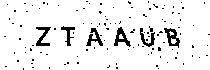

In [173]:
processed_image_pil

In [176]:

# pytesseract로 텍스트 추출
page_text = pytesseract.image_to_string(processed_image_pil, lang='Eng')

print("추출된 텍스트:", page_text)

추출된 텍스트: 


In [156]:
from PIL import Image
# 이미지에서 텍스트 추출



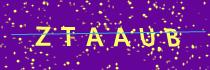

In [159]:
captcha_image

In [165]:
image

array([[  0,   0,   0, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [  0, 255,   0, ..., 255,   0,   0],
       ...,
       [255,   0,   0, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255,   0],
       [  0, 255,   0, ..., 255,   0,   0]], dtype=uint8)

In [160]:
page_text = pytesseract.image_to_string(captcha_image, lang='eng')


In [161]:
page_text

''

In [ ]:
# 일시적 이미지 파일 삭제
# os.remove(temp_image_path)

In [152]:
text = extract_text_from_captcha()
text

'ZFAAVUB'

driver.page_source

In [118]:
# 예매하기 버튼 클릭 후 팝업 창으로 전환
main_window = driver.current_window_handle  # 현재 창의 핸들 저장
all_windows = driver.window_handles

# 새로운 팝업 창으로 전환
for window in all_windows:
    if window != main_window:
        driver.switch_to.window(window)
        break

In [128]:
# 예매하기 버튼 클릭 후 팝업 창으로 전환
main_window = driver.current_window_handle  # 현재 창의 핸들 저장
all_windows = driver.window_handles

# 새로운 팝업 창으로 전환
for window in all_windows:
    if window != main_window:
        driver.switch_to.window(window)
        break

In [129]:
driver.page_source

'<html lang="ko"><head><script type="text/javascript" async="" src="https://www.google-analytics.com/plugins/ua/ec.js"></script><script type="text/javascript" async="" src="https://www.google-analytics.com/analytics.js"></script><script type="text/javascript" async="" src="https://js.appboycdn.com/web-sdk/3.2/appboy.min.js"></script><script src="https://connect.facebook.net/signals/config/929060091512589?v=2.9.165&amp;r=stable&amp;domain=tickets.interpark.com&amp;hme=da9a399065fb1c492026018b9e54864148adfb49d800f41752428fb7b59190f8&amp;ex_m=69%2C118%2C104%2C108%2C60%2C4%2C97%2C68%2C16%2C94%2C86%2C50%2C53%2C168%2C171%2C183%2C179%2C180%2C182%2C29%2C98%2C52%2C75%2C181%2C163%2C166%2C176%2C177%2C184%2C127%2C40%2C34%2C139%2C15%2C49%2C190%2C189%2C129%2C18%2C39%2C1%2C42%2C64%2C65%2C66%2C70%2C90%2C17%2C14%2C93%2C89%2C88%2C105%2C51%2C107%2C38%2C106%2C30%2C91%2C26%2C164%2C167%2C136%2C28%2C11%2C12%2C13%2C6%2C7%2C25%2C22%2C23%2C56%2C61%2C63%2C73%2C99%2C27%2C74%2C9%2C8%2C78%2C47%2C21%2C101%2C100%2C10

In [125]:
images = driver.find_elements(By.TAG_NAME, "img")
for img in images:
    src = img.get_attribute("src")
    print(src)
    # if "captcha" in src:
        # print("캡차 이미지를 찾았습니다.")
        # img.click()  # 또는 img.screenshot("captcha.png")와 같은 작업 수행
        # break

http://ticketimage.interpark.com/TicketImage/onestop/h_logo.gif
http://ticketimage.interpark.com/TicketImage/onestop/05_step_01_back.gif
http://ticketimage.interpark.com/TicketImage/onestop/05_step_02_on.gif
http://ticketimage.interpark.com/TicketImage/onestop/05_step_03_off.gif
http://ticketimage.interpark.com/TicketImage/onestop/05_step_04_off.gif
http://ticketimage.interpark.com/TicketImage/onestop/05_step_05_off.gif
http://ticketimage.interpark.com/Play/image/large/24/24011165_p.gif
http://ticketimage.interpark.com/TicketImage/onestop/tit_buy.gif
http://ticketimage.interpark.com/TicketImage/onestop/btn_detail.gif
http://ticketimage.interpark.com/TicketImage/onestop/btn_next_on.gif
https://ticketimage.interpark.com/TicketImage/onestop/loading_2.gif
https://ticketimage.interpark.com/TicketImage/onestop/btn_pre.gif
http://ticketimage.interpark.com/TicketImage/onestop/btn_next_02.gif
https://ticketimage.interpark.com/TicketImage/onestop/btn_lay_close1.gif


In [127]:
# 현재 페이지의 HTML 소스를 가져와서 파일로 저장
page_source = driver.page_source

# 파일로 저장할 경로와 파일명 지정
file_path = "page_source.html"

# HTML 소스를 파일로 저장
with open(file_path, "w", encoding="utf-8") as file:
    file.write(page_source)

print(f"페이지 소스가 {file_path}로 저장되었습니다.")


페이지 소스가 page_source.html로 저장되었습니다.


In [134]:
# 새로운 탭으로 이동
print(driver.window_handles)
driver.switch_to.window(driver.window_handles[-1])

# 아이프레임으로 이동
driver.switch_to.frame(driver.find_element(By.XPATH, "//*[@id='ifrmSeat']"))

['3B2895E246A0B876CC84DB5290B97CE6', '36D8847D2DC3537FC1168F997789E04B', 'DC90D3217224F7C31F7EC35F880315ED']


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='ifrmSeat']"}
  (Session info: chrome=127.0.6533.120); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00D18923+23283]
	(No symbol) [0x00CDE934]
	(No symbol) [0x00C10733]
	(No symbol) [0x00C5326F]
	(No symbol) [0x00C534AB]
	(No symbol) [0x00C8EE42]
	(No symbol) [0x00C74464]
	(No symbol) [0x00C8CB8D]
	(No symbol) [0x00C741B6]
	(No symbol) [0x00C48017]
	(No symbol) [0x00C4890D]
	GetHandleVerifier [0x00E0A5F3+1013699]
	GetHandleVerifier [0x00E13E4C+1052700]
	GetHandleVerifier [0x00E0D4B4+1025668]
	GetHandleVerifier [0x00D3EA2B+179195]
	(No symbol) [0x00CE6833]
	(No symbol) [0x00CE3198]
	(No symbol) [0x00CE3337]
	(No symbol) [0x00CDB4BE]
	BaseThreadInitThunk [0x771FFCC9+25]
	RtlGetAppContainerNamedObjectPath [0x77DF80CE+286]
	RtlGetAppContainerNamedObjectPath [0x77DF809E+238]


In [133]:
driver.find_elements(By.XPATH)

InvalidArgumentException: Message: invalid argument: 'value' must be a string
  (Session info: chrome=127.0.6533.120)
Stacktrace:
	GetHandleVerifier [0x00D18923+23283]
	(No symbol) [0x00CDE934]
	(No symbol) [0x00C10733]
	(No symbol) [0x00C52C21]
	(No symbol) [0x00C534AB]
	(No symbol) [0x00C8EE7C]
	(No symbol) [0x00C74464]
	(No symbol) [0x00C8CB8D]
	(No symbol) [0x00C741B6]
	(No symbol) [0x00C48017]
	(No symbol) [0x00C4890D]
	GetHandleVerifier [0x00E0A5F3+1013699]
	GetHandleVerifier [0x00E13E4C+1052700]
	GetHandleVerifier [0x00E0D4B4+1025668]
	GetHandleVerifier [0x00D3EA2B+179195]
	(No symbol) [0x00CE6833]
	(No symbol) [0x00CE3198]
	(No symbol) [0x00CE3337]
	(No symbol) [0x00CDB4BE]
	BaseThreadInitThunk [0x771FFCC9+25]
	RtlGetAppContainerNamedObjectPath [0x77DF80CE+286]
	RtlGetAppContainerNamedObjectPath [0x77DF809E+238]


In [132]:
# iframe 이동
# driver.switch_to.frame(driver.find_element(By.XPATH, "//*[@id='ifrmSeat']"))

# 입력해야될 문자 이미지 캡쳐하기.
# capchaPng = driver.find_element(By.XPATH, "//*[@id='imgCaptcha']")


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='imgCaptcha']"}
  (Session info: chrome=127.0.6533.120); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00D18923+23283]
	(No symbol) [0x00CDE934]
	(No symbol) [0x00C10733]
	(No symbol) [0x00C5326F]
	(No symbol) [0x00C534AB]
	(No symbol) [0x00C8EE42]
	(No symbol) [0x00C74464]
	(No symbol) [0x00C8CB8D]
	(No symbol) [0x00C741B6]
	(No symbol) [0x00C48017]
	(No symbol) [0x00C4890D]
	GetHandleVerifier [0x00E0A5F3+1013699]
	GetHandleVerifier [0x00E13E4C+1052700]
	GetHandleVerifier [0x00E0D4B4+1025668]
	GetHandleVerifier [0x00D3EA2B+179195]
	(No symbol) [0x00CE6833]
	(No symbol) [0x00CE3198]
	(No symbol) [0x00CE3337]
	(No symbol) [0x00CDB4BE]
	BaseThreadInitThunk [0x771FFCC9+25]
	RtlGetAppContainerNamedObjectPath [0x77DF80CE+286]
	RtlGetAppContainerNamedObjectPath [0x77DF809E+238]


In [119]:
def save_captcha_image():
    captcha_image_element = driver.find_element(by=By.ID, value="imgCaptcha")
    captcha_image = captcha_image_element.screenshot_as_png
    with open(TMP_CAPTCHA_IMAGE_PATH, "wb") as f:
        f.write(captcha_image)

In [120]:
save_captcha_image()

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="imgCaptcha"]"}
  (Session info: chrome=127.0.6533.120); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00D18923+23283]
	(No symbol) [0x00CDE934]
	(No symbol) [0x00C10733]
	(No symbol) [0x00C5326F]
	(No symbol) [0x00C534AB]
	(No symbol) [0x00C8EE42]
	(No symbol) [0x00C74464]
	(No symbol) [0x00C8CB8D]
	(No symbol) [0x00C741B6]
	(No symbol) [0x00C48017]
	(No symbol) [0x00C4890D]
	GetHandleVerifier [0x00E0A5F3+1013699]
	GetHandleVerifier [0x00E13E4C+1052700]
	GetHandleVerifier [0x00E0D4B4+1025668]
	GetHandleVerifier [0x00D3EA2B+179195]
	(No symbol) [0x00CE6833]
	(No symbol) [0x00CE3198]
	(No symbol) [0x00CE3337]
	(No symbol) [0x00CDB4BE]
	BaseThreadInitThunk [0x771FFCC9+25]
	RtlGetAppContainerNamedObjectPath [0x77DF80CE+286]
	RtlGetAppContainerNamedObjectPath [0x77DF809E+238]


In [ ]:
# ref: https://github.com/clyde0813/Interpark-Ticketing/blob/main/interpark.py
def captcha(driver: WebDriver):
    def save_captcha_image():
        captcha_image_element = driver.find_element(by=By.ID, value="imgCaptcha")
        captcha_image = captcha_image_element.screenshot_as_png
        with open(TMP_CAPTCHA_IMAGE_PATH, "wb") as f:
            f.write(captcha_image)

    def extract_text_from_captcha():
        image = cv.imread(str(TMP_CAPTCHA_IMAGE_PATH))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        image = cv.adaptiveThreshold(
            image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 91, 1
        )
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
        image = cv.morphologyEx(image, cv.MORPH_OPEN, kernel, iterations=1)

        cnts = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            area = cv.contourArea(c)
            if area < 50:
                cv.drawContours(image, [c], -1, (0, 0, 0), -1)
        kernel2 = numpy.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        image = cv.filter2D(image, -1, kernel2)
        result = 255 - image

        captcha_text = image_to_string(result)
        captcha_text = re.sub("[^A-Z]", "", captcha_text) or "A"  # 빈 텍스트인 경우 아무거나 넣어줌
        return captcha_text

    def submit_captcha(captcha_text: str):
        captcha_input = driver.find_element(by=By.ID, value="txtCaptcha")
        captcha_input.send_keys(captcha_text)

        captcha_submit_button = driver.find_element(
            by=By.XPATH, value="/html/body/div/div/div/div/div[3]"
        )
        captcha_submit_button.click()

    def retry_if_wrong():
        try:
            captcha_wrong_alert = driver.find_element(
                by=By.XPATH, value="/html/body/div/div/div/div/div[2]/div"
            )

            if captcha_wrong_alert.get_attribute("class") == "alert":
                driver.execute_script("reloadCapcha();")
                captcha(driver)
        except NoSuchElementException:  # 성공한 경우 없어짐
            pass

    WebDriverWait(driver, WAIT_LIMIT_IN_SECONDS).until(
        EC.presence_of_element_located((By.ID, "imgCaptcha"))
    )

    save_captcha_image()
    captcha_text = extract_text_from_captcha()
    submit_captcha(captcha_text)
    retry_if_wrong()

    if TMP_CAPTCHA_IMAGE_PATH.exists():
        remove(TMP_CAPTCHA_IMAGE_PATH)

In [8]:
class LoopEndException(Exception):
    pass

class BuyFailException(Exception):
    pass


In [7]:
print_msg(msg='hi')

[2024-08-20T23:02:43] hi
